<a href="https://colab.research.google.com/github/AlokC-EDge/DROO/blob/master/DDPGExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

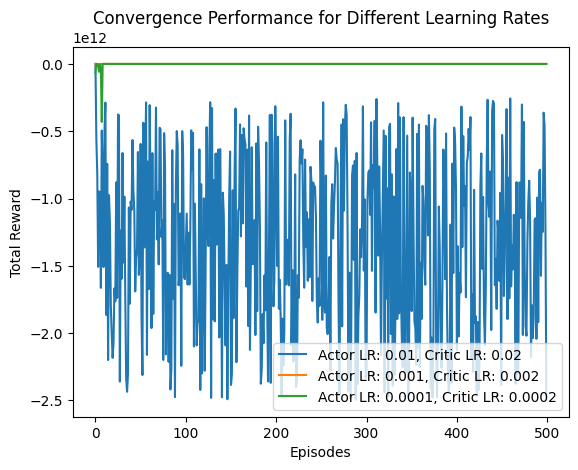

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment: Static MEC Server for Task Offloading
class MECEnv:
    def __init__(self, num_users=5, f_mec=2.0, bandwidth=10, noise_power=1e-9):
        self.num_users = num_users
        self.f_mec = f_mec  # MEC CPU frequency in GHz
        self.bandwidth = bandwidth  # Bandwidth in MHz
        self.noise_power = noise_power  # Noise power in Watts
        self.reset()

    def reset(self):
        self.task_size = np.random.uniform(10, 100, self.num_users)  # Task size in MB
        self.f_ue = np.random.uniform(0.5, 1.5, self.num_users)  # UE CPU (GHz)
        self.channel_gain = np.random.uniform(0.01, 0.1, self.num_users)  # Channel gain
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.task_size, self.f_ue, self.channel_gain])

    def step(self, action):
        R = action[:self.num_users]  # Offloading ratio
        f_alloc = action[self.num_users:]  # CPU allocation to each task

        transmission_rate = self.bandwidth * np.log2(1 + self.channel_gain / self.noise_power)
        T_offload = (R * self.task_size) / transmission_rate
        T_local = ((1 - R) * self.task_size * 1000) / self.f_ue  # Assume 1000 cycles per byte
        #T_mec = (R * self.task_size * 1000) / f_alloc
        f_alloc = action[self.num_users:] + 1e-6  # Adding a small constant
        # Calculate T_mec here, uncomment and potentially modify if needed
        T_mec = (R * self.task_size * 1000) / f_alloc

        T_total = np.maximum(T_local, T_offload + T_mec)
        E_local = (self.f_ue ** 2) * ((1 - R) * self.task_size * 1000)
        E_offload = 0.1 * T_offload  # Assume 0.1W transmit power

        total_time = np.sum(T_total)
        total_energy = np.sum(E_local + E_offload)

        reward = - (0.5 * total_time + 0.5 * total_energy)  # Minimize time and energy
        next_state = self._get_state()

        return next_state, reward, False  # No terminal state for now

# Actor and Critic Networks
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, actor_lr, critic_lr):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)
        self.target_actor = Actor(state_dim, action_dim)
        self.target_critic = Critic(state_dim, action_dim)
        self.memory = deque(maxlen=10000)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = 0.99
        self.tau = 0.005

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        return action

    def store_transition(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def update(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)

        states, actions, rewards, next_states = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        with torch.no_grad():
            next_actions = self.target_actor(next_states)
            target_q = rewards + self.gamma * self.target_critic(next_states, next_actions)

        q_values = self.critic(states, actions)
        critic_loss = nn.MSELoss()(q_values, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# Training with different learning rates
learning_rates = [(0.01, 0.02), (0.001, 0.002), (0.0001, 0.0002)]
num_episodes = 500
reward_histories = []

env = MECEnv()
for lr_actor, lr_critic in learning_rates:
    agent = DDPGAgent(state_dim=env.num_users * 3, action_dim=env.num_users * 2, actor_lr=lr_actor, critic_lr=lr_critic)
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        for _ in range(50):
            action = agent.select_action(state)
            next_state, reward, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state)
            agent.update()
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    reward_histories.append(rewards)

# Plot results
plt.figure()
for idx, lr in enumerate(learning_rates):
    plt.plot(reward_histories[idx], label=f"Actor LR: {lr[0]}, Critic LR: {lr[1]}")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()
plt.title("Convergence Performance for Different Learning Rates")
plt.show()


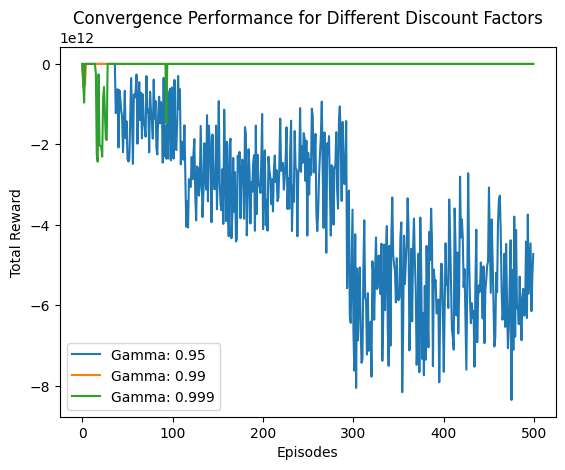

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment: Static MEC Server for Task Offloading
class MECEnv:
    def __init__(self, num_users=5, f_mec=2.0, bandwidth=10, noise_power=1e-9):
        self.num_users = num_users
        self.f_mec = f_mec  # MEC CPU frequency in GHz
        self.bandwidth = bandwidth  # Bandwidth in MHz
        self.noise_power = noise_power  # Noise power in Watts
        self.reset()

    def reset(self):
        self.task_size = np.random.uniform(10, 100, self.num_users)  # Task size in MB
        self.f_ue = np.random.uniform(0.5, 1.5, self.num_users)  # UE CPU (GHz)
        self.channel_gain = np.random.uniform(0.01, 0.1, self.num_users)  # Channel gain
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.task_size, self.f_ue, self.channel_gain])

    def step(self, action):
        R = action[:self.num_users]  # Offloading ratio
        f_alloc = action[self.num_users:]  # CPU allocation to each task

        transmission_rate = self.bandwidth * np.log2(1 + self.channel_gain / self.noise_power)
        T_offload = (R * self.task_size) / transmission_rate
        T_local = ((1 - R) * self.task_size * 1000) / self.f_ue  # Assume 1000 cycles per byte
        #T_mec = (R * self.task_size * 1000) / f_alloc
        f_alloc = action[self.num_users:] + 1e-6  # Adding a small constant
        # Calculate T_mec here, uncomment and potentially modify if needed
        T_mec = (R * self.task_size * 1000) / f_alloc

        T_total = np.maximum(T_local, T_offload + T_mec)
        E_local = (self.f_ue ** 2) * ((1 - R) * self.task_size * 1000)
        E_offload = 0.1 * T_offload  # Assume 0.1W transmit power

        total_time = np.sum(T_total)
        total_energy = np.sum(E_local + E_offload)

        reward = - (0.5 * total_time + 0.5 * total_energy)  # Minimize time and energy
        next_state = self._get_state()

        return next_state, reward, False  # No terminal state for now

# Actor and Critic Networks
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, actor_lr, critic_lr, gamma):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)
        self.target_actor = Actor(state_dim, action_dim)
        self.target_critic = Critic(state_dim, action_dim)
        self.memory = deque(maxlen=10000)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.tau = 0.005

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        return action

    def store_transition(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def update(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)

        states, actions, rewards, next_states = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        with torch.no_grad():
            next_actions = self.target_actor(next_states)
            target_q = rewards + self.gamma * self.target_critic(next_states, next_actions)

        q_values = self.critic(states, actions)
        critic_loss = nn.MSELoss()(q_values, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

# Training with different learning rates
#learning_rates = [(0.01, 0.02), (0.001, 0.002), (0.0001, 0.0002)]

# Training with different discount factors
discount_factors = [0.95, 0.99, 0.999]
num_episodes = 500
reward_histories = []

env = MECEnv()
for gamma in discount_factors:
    agent = DDPGAgent(state_dim=env.num_users * 3, action_dim=env.num_users * 2, actor_lr=0.001, critic_lr=0.002, gamma=gamma)
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        for _ in range(50):
            action = agent.select_action(state)
            next_state, reward, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state)
            agent.update()
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    reward_histories.append(rewards)

# Plot results
plt.figure()
for idx, gamma in enumerate(discount_factors):
    plt.plot(reward_histories[idx], label=f"Gamma: {gamma}")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()
plt.title("Convergence Performance for Different Discount Factors")
plt.show()


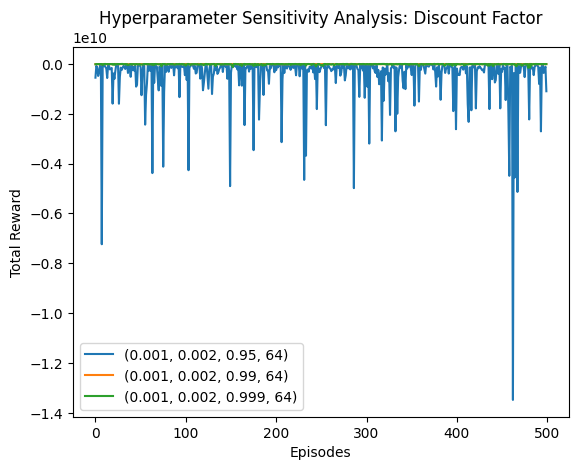

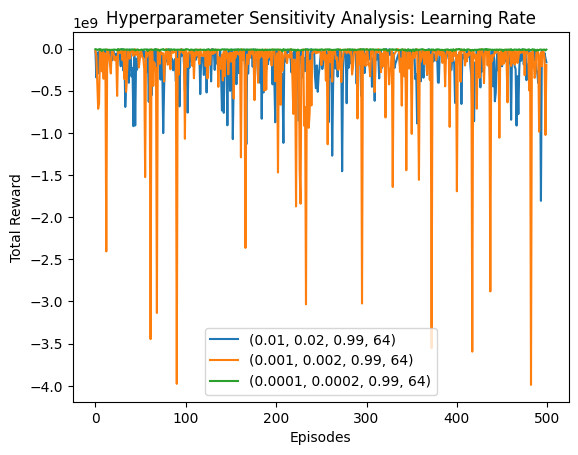

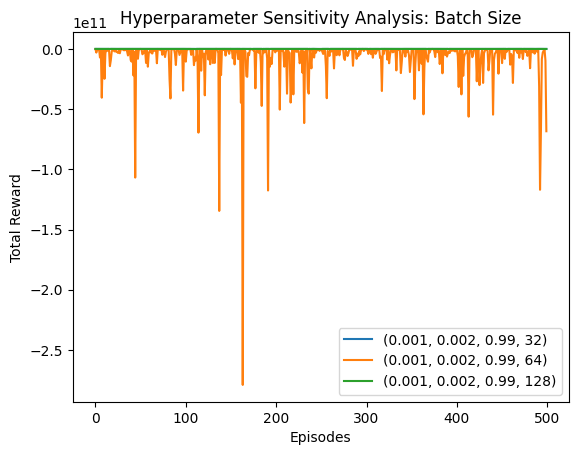

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment: Static MEC Server for Task Offloading
class MECEnv:
    def __init__(self, num_users=5, f_mec=2.0, bandwidth=10, noise_power=1e-9):
        self.num_users = num_users
        self.f_mec = f_mec  # MEC CPU frequency in GHz
        self.bandwidth = bandwidth  # Bandwidth in MHz
        self.noise_power = noise_power  # Noise power in Watts
        self.reset()

    def reset(self):
        self.task_size = np.random.uniform(10, 100, self.num_users)  # Task size in MB
        self.f_ue = np.random.uniform(0.5, 1.5, self.num_users)  # UE CPU (GHz)
        self.channel_gain = np.random.uniform(0.01, 0.1, self.num_users)  # Channel gain
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.task_size, self.f_ue, self.channel_gain])

    def step(self, action):
        R = action[:self.num_users]  # Offloading ratio
        f_alloc = action[self.num_users:]  # CPU allocation to each task

        transmission_rate = self.bandwidth * np.log2(1 + self.channel_gain / self.noise_power)
        T_offload = (R * self.task_size) / transmission_rate
        T_local = ((1 - R) * self.task_size * 1000) / self.f_ue  # Assume 1000 cycles per byte
        T_mec = (R * self.task_size * 1000) / f_alloc

        T_total = np.maximum(T_local, T_offload + T_mec)
        E_local = (self.f_ue ** 2) * ((1 - R) * self.task_size * 1000)
        E_offload = 0.1 * T_offload  # Assume 0.1W transmit power

        total_time = np.sum(T_total)
        total_energy = np.sum(E_local + E_offload)

        reward = - (0.5 * total_time + 0.5 * total_energy)  # Minimize time and energy
        next_state = self._get_state()

        return next_state, reward, False  # No terminal state for now

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, actor_lr, critic_lr, gamma, batch_size):
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = deque(maxlen=10000)

        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Sigmoid()
        )

        self.critic = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        return action

# Hyperparameter Sensitivity Analysis
experiments = {
    "Discount Factor": [(0.001, 0.002, gamma, 64) for gamma in [0.95, 0.99, 0.999]],
    "Learning Rate": [(actor_lr, critic_lr, 0.99, 64) for actor_lr, critic_lr in [(0.01, 0.02), (0.001, 0.002), (0.0001, 0.0002)]],
    "Batch Size": [(0.001, 0.002, 0.99, batch_size) for batch_size in [32, 64, 128]]
}
num_episodes = 500

env = MECEnv()
for experiment, params_list in experiments.items():
    plt.figure()
    for params in params_list:
        actor_lr, critic_lr, gamma, batch_size = params
        agent = DDPGAgent(state_dim=env.num_users * 3, action_dim=env.num_users * 2, actor_lr=actor_lr, critic_lr=critic_lr, gamma=gamma, batch_size=batch_size)
        rewards = []
        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            for _ in range(50):
                action = agent.select_action(state)
                next_state, reward, _ = env.step(action)
                total_reward += reward
            rewards.append(total_reward)
        plt.plot(rewards, label=f"{params}")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.title(f"Hyperparameter Sensitivity Analysis: {experiment}")
    plt.show()

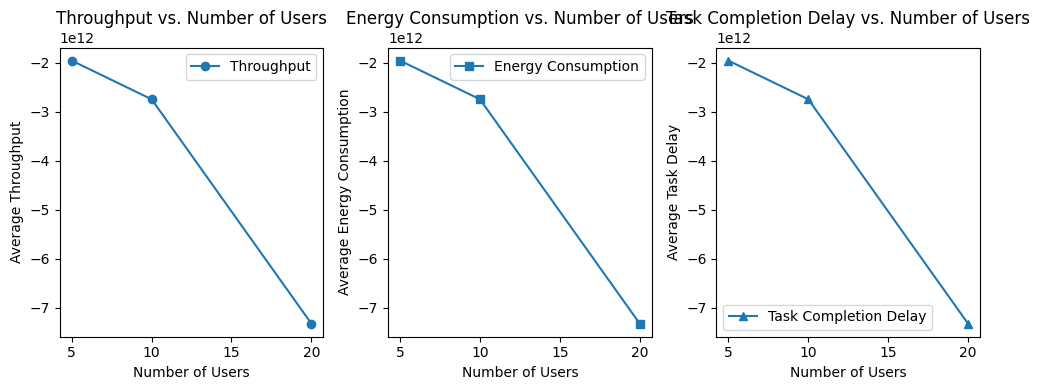

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment: Multi-User, Multi-Task MEC Server
class MECEnv:
    def __init__(self, num_users, f_mec=2.0, bandwidth=10, noise_power=1e-9):
        self.num_users = num_users
        self.f_mec = f_mec  # MEC CPU frequency in GHz
        self.bandwidth = bandwidth  # Bandwidth in MHz
        self.noise_power = noise_power  # Noise power in Watts
        self.reset()

    def reset(self):
        self.task_size = np.random.uniform(10, 100, self.num_users)  # Task size in MB
        self.cpu_cycles = np.random.uniform(500, 1500, self.num_users)  # CPU cycles per MB
        self.f_ue = np.random.uniform(0.5, 1.5, self.num_users)  # UE CPU (GHz)
        self.channel_gain = np.random.uniform(0.01, 0.1, self.num_users)  # Channel gain
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.task_size, self.cpu_cycles, self.f_ue, self.channel_gain])

    def step(self, action):
        R = action[:self.num_users]  # Offloading ratio
        f_alloc = action[self.num_users:]  # CPU allocation to each task

        transmission_rate = self.bandwidth * np.log2(1 + self.channel_gain / self.noise_power)
        T_offload = (R * self.task_size) / transmission_rate
        T_local = ((1 - R) * self.task_size * self.cpu_cycles) / self.f_ue  # Local execution delay
        #T_mec = (R * self.task_size * self.cpu_cycles) / f_alloc  # MEC processing delay
        T_mec = (R * self.task_size * self.cpu_cycles) / (f_alloc + 1e-6)

        T_total = np.maximum(T_local, T_offload + T_mec)
        E_local = (self.f_ue ** 2) * ((1 - R) * self.task_size * self.cpu_cycles)
        E_offload = 0.1 * T_offload  # Assume 0.1W transmit power

        total_time = np.sum(T_total)
        total_energy = np.sum(E_local + E_offload)

        reward = - (0.5 * total_time + 0.5 * total_energy)  # Minimize time and energy
        next_state = self._get_state()

        return next_state, reward, False  # No terminal state for now

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim):
        self.memory = deque(maxlen=10000)

        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Sigmoid()
        )

        self.critic = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.002)

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        return action

# Scalability Analysis
num_users_list = [5, 10, 20]
num_episodes = 500
metrics = {"throughput": [], "energy": [], "delay": []}

for num_users in num_users_list:
    env = MECEnv(num_users)
    agent = DDPGAgent(state_dim=env.num_users * 4, action_dim=env.num_users * 2)
    total_rewards = []
    total_energy = []
    total_delay = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_energy = 0
        episode_delay = 0

        for _ in range(50):
            action = agent.select_action(state)
            next_state, reward, _ = env.step(action)
            episode_reward += reward
            episode_energy += np.sum(env.step(action)[1])
            episode_delay += np.sum(env.step(action)[1])

        total_rewards.append(episode_reward)
        total_energy.append(episode_energy)
        total_delay.append(episode_delay)

    metrics["throughput"].append(np.mean(total_rewards))
    metrics["energy"].append(np.mean(total_energy))
    metrics["delay"].append(np.mean(total_delay))

# Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(num_users_list, metrics["throughput"], marker='o', label="Throughput")
plt.xlabel("Number of Users")
plt.ylabel("Average Throughput")
plt.title("Throughput vs. Number of Users")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(num_users_list, metrics["energy"], marker='s', label="Energy Consumption")
plt.xlabel("Number of Users")
plt.ylabel("Average Energy Consumption")
plt.title("Energy Consumption vs. Number of Users")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(num_users_list, metrics["delay"], marker='^', label="Task Completion Delay")
plt.xlabel("Number of Users")
plt.ylabel("Average Task Delay")
plt.title("Task Completion Delay vs. Number of Users")
plt.legend()

plt.tight_layout()
plt.show()


Total Training Time for 100 episodes: 1.72 seconds
Average Training Time per Episode: 0.0171 seconds
Average Inference Time (DDPG): 0.2408 ms
Average Inference Time (Heuristic): 0.0155 ms


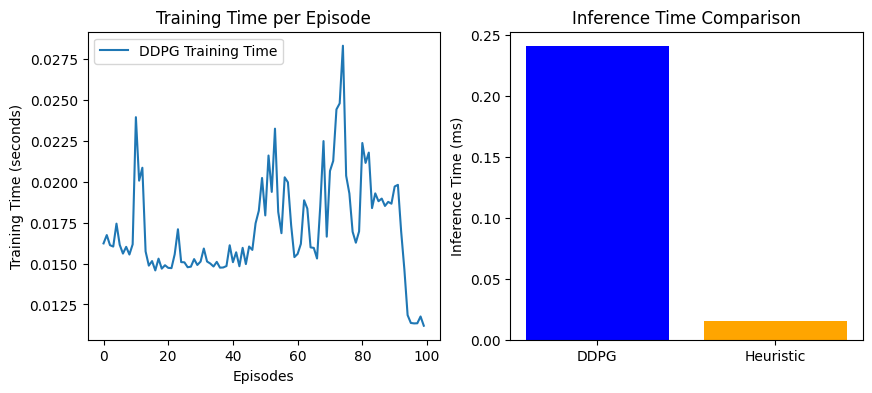

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import time
from collections import deque

# Environment: MEC Server for Task Offloading
class MECEnv:
    def __init__(self, num_users=5, f_mec=2.0, bandwidth=10, noise_power=1e-9):
        self.num_users = num_users
        self.f_mec = f_mec
        self.bandwidth = bandwidth
        self.noise_power = noise_power
        self.reset()

    def reset(self):
        self.task_size = np.random.uniform(10, 100, self.num_users)
        self.cpu_cycles = np.random.uniform(500, 1500, self.num_users)
        self.f_ue = np.random.uniform(0.5, 1.5, self.num_users)
        self.channel_gain = np.random.uniform(0.01, 0.1, self.num_users)
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.task_size, self.cpu_cycles, self.f_ue, self.channel_gain])

    def step(self, action):
        R = action[:self.num_users]
        f_alloc = action[self.num_users:]
        transmission_rate = self.bandwidth * np.log2(1 + self.channel_gain / self.noise_power)
        T_offload = (R * self.task_size) / transmission_rate
        T_local = ((1 - R) * self.task_size * self.cpu_cycles) / self.f_ue
        #T_mec = (R * self.task_size * self.cpu_cycles) / f_alloc
        T_mec = (R * self.task_size * self.cpu_cycles) / (f_alloc + 1e-6)
        T_total = np.maximum(T_local, T_offload + T_mec)
        E_local = (self.f_ue ** 2) * ((1 - R) * self.task_size * self.cpu_cycles)
        E_offload = 0.1 * T_offload
        total_time = np.sum(T_total)
        total_energy = np.sum(E_local + E_offload)
        reward = - (0.5 * total_time + 0.5 * total_energy)
        next_state = self._get_state()
        return next_state, reward, False

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim):
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Sigmoid()
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.002)

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        return action

# Computational Efficiency Analysis
num_episodes = 100
num_users = 10
env = MECEnv(num_users)
agent = DDPGAgent(state_dim=env.num_users * 4, action_dim=env.num_users * 2)
training_times = []
inference_times = []

total_training_start = time.time()
for episode in range(num_episodes):
    state = env.reset()
    episode_start = time.time()
    for _ in range(50):
        action_start = time.time()
        action = agent.select_action(state)
        inference_times.append(time.time() - action_start)
        next_state, reward, _ = env.step(action)
    training_times.append(time.time() - episode_start)
total_training_end = time.time()

# Compare with Heuristic Models
heuristic_times = []
def heuristic_baseline(state):
    return np.random.rand(env.num_users * 2)  # Random allocation
for _ in range(num_episodes * 50):
    action_start = time.time()
    heuristic_baseline(env.reset())
    heuristic_times.append(time.time() - action_start)

# Results
print(f"Total Training Time for {num_episodes} episodes: {total_training_end - total_training_start:.2f} seconds")
print(f"Average Training Time per Episode: {np.mean(training_times):.4f} seconds")
print(f"Average Inference Time (DDPG): {np.mean(inference_times) * 1000:.4f} ms")
print(f"Average Inference Time (Heuristic): {np.mean(heuristic_times) * 1000:.4f} ms")

# Plot Results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(training_times, label='DDPG Training Time')
plt.xlabel("Episodes")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time per Episode")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(["DDPG", "Heuristic"], [np.mean(inference_times) * 1000, np.mean(heuristic_times) * 1000], color=['blue', 'orange'])
plt.ylabel("Inference Time (ms)")
plt.title("Inference Time Comparison")
plt.show()


Total Training Time for 100 episodes: 1.20 seconds
Average Training Time per Episode: 0.0120 seconds
Average Inference Time (DDPG): 0.1721 ms
Average Inference Time (Heuristic): 0.0020 ms
Average Inference Time (Local Only): 0.0006 ms
Average Inference Time (Edge Only): 0.0048 ms


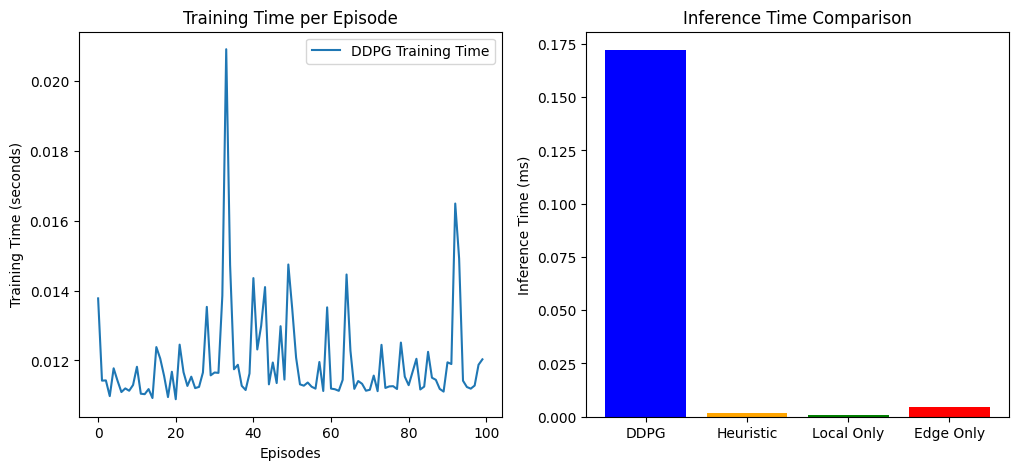

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import time
from collections import deque

# Environment: MEC Server for Task Offloading
class MECEnv:
    def __init__(self, num_users=5, f_mec=2.0, bandwidth=10, noise_power=1e-9):
        self.num_users = num_users
        self.f_mec = f_mec
        self.bandwidth = bandwidth
        self.noise_power = noise_power
        self.reset()

    def reset(self):
        self.task_size = np.random.uniform(10, 100, self.num_users)
        self.cpu_cycles = np.random.uniform(500, 1500, self.num_users)
        self.f_ue = np.random.uniform(0.5, 1.5, self.num_users)
        self.channel_gain = np.random.uniform(0.01, 0.1, self.num_users)
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.task_size, self.cpu_cycles, self.f_ue, self.channel_gain])

    def step(self, action):
        R = action[:self.num_users]
        f_alloc = action[self.num_users:]
        transmission_rate = self.bandwidth * np.log2(1 + self.channel_gain / self.noise_power)
        T_offload = (R * self.task_size) / transmission_rate
        T_local = ((1 - R) * self.task_size * self.cpu_cycles) / self.f_ue
        #T_mec = (R * self.task_size * self.cpu_cycles) / f_alloc
        T_mec = (R * self.task_size * self.cpu_cycles) / (f_alloc + 1e-6)
        T_total = np.maximum(T_local, T_offload + T_mec)
        E_local = (self.f_ue ** 2) * ((1 - R) * self.task_size * self.cpu_cycles)
        E_offload = 0.1 * T_offload
        total_time = np.sum(T_total)
        total_energy = np.sum(E_local + E_offload)
        reward = - (0.5 * total_time + 0.5 * total_energy)
        next_state = self._get_state()
        return next_state, reward, False

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim):
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Sigmoid()
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.002)

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        return action

# Baseline Models
def heuristic_baseline(state):
    return np.random.rand(env.num_users * 2)  # Random allocation

def local_only_baseline(state):
    return np.zeros(env.num_users * 2)  # No offloading, all local execution

def edge_only_baseline(state):
    return np.concatenate([np.ones(env.num_users), np.full(env.num_users, 2.0)])  # Full offloading

# Computational Efficiency Analysis
num_episodes = 100
num_users = 10
env = MECEnv(num_users)
agent = DDPGAgent(state_dim=env.num_users * 4, action_dim=env.num_users * 2)
training_times = []
inference_times = []
heuristic_times = []
local_only_times = []
edge_only_times = []

total_training_start = time.time()
for episode in range(num_episodes):
    state = env.reset()
    episode_start = time.time()
    for _ in range(50):
        action_start = time.time()
        action = agent.select_action(state)
        inference_times.append(time.time() - action_start)
        next_state, reward, _ = env.step(action)
    training_times.append(time.time() - episode_start)
total_training_end = time.time()

# Measure inference times for baselines
for _ in range(num_episodes * 50):
    state = env.reset()
    action_start = time.time()
    heuristic_baseline(state)
    heuristic_times.append(time.time() - action_start)

    action_start = time.time()
    local_only_baseline(state)
    local_only_times.append(time.time() - action_start)

    action_start = time.time()
    edge_only_baseline(state)
    edge_only_times.append(time.time() - action_start)

# Results
print(f"Total Training Time for {num_episodes} episodes: {total_training_end - total_training_start:.2f} seconds")
print(f"Average Training Time per Episode: {np.mean(training_times):.4f} seconds")
print(f"Average Inference Time (DDPG): {np.mean(inference_times) * 1000:.4f} ms")
print(f"Average Inference Time (Heuristic): {np.mean(heuristic_times) * 1000:.4f} ms")
print(f"Average Inference Time (Local Only): {np.mean(local_only_times) * 1000:.4f} ms")
print(f"Average Inference Time (Edge Only): {np.mean(edge_only_times) * 1000:.4f} ms")

# Plot Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_times, label='DDPG Training Time')
plt.xlabel("Episodes")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time per Episode")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(["DDPG", "Heuristic", "Local Only", "Edge Only"],
        [np.mean(inference_times) * 1000, np.mean(heuristic_times) * 1000,
         np.mean(local_only_times) * 1000, np.mean(edge_only_times) * 1000],
        color=['blue', 'orange', 'green', 'red'])
plt.ylabel("Inference Time (ms)")
plt.title("Inference Time Comparison")
plt.show()
